In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [109]:
df = pd.read_csv('../datasets/Mall_Customers.csv')

In [110]:
# Map genders to numbers
gender_map = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].replace(gender_map)

C:\Users\SER5\AppData\Local\Temp\ipykernel_14964\1484665196.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace(gender_map)


In [111]:
# Define spending categories based on score thresholds
def categorize_spending(score):
    if score < 33:
        return 1
    elif score <= 66:
        return 2
    else:
        return 3

In [112]:
# Apply the categorization function to create a new column 'Spending Category'
df['Spending Category'] = df['Spending Score (1-100)'].apply(categorize_spending)
df.drop(columns=['CustomerID'], inplace=True)
df.drop(columns=['Spending Score (1-100)'], inplace=True)

In [113]:
X = df.drop('Spending Category', axis=1)
y = df['Spending Category']

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_rescaled, columns=X.columns)

# One-hot encoding
y = pd.get_dummies(y)

In [114]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
def create_model_and_train(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=3, max_value=45, step=3),
                    activation='relu', input_shape=(X_train.shape[1],)))

    # Add hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=3, max_value=45, step=3), activation='relu'))

    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
    
    return model

# Define tuner
tuner = RandomSearch(
    create_model_and_train,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='hyperparameter_tuning',
    project_name='mall_customers'
)

# Hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Retrieve best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('../models/nn.keras')

Reloading Tuner from hyperparameter_tuning\mall_customers\tuner0.json
Epoch 1/50


c:\Users\SER5\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2750 - loss: 1.0923 - val_accuracy: 0.5312 - val_loss: 0.9990
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4490 - loss: 1.0420 - val_accuracy: 0.5312 - val_loss: 0.9716
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4365 - loss: 1.0222 - val_accuracy: 0.4688 - val_loss: 0.9549
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4865 - loss: 0.9542 - val_accuracy: 0.4688 - val_loss: 0.9223
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5521 - loss: 0.9458 - val_accuracy: 0.5625 - val_loss: 0.8953
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5542 - loss: 0.8930 - val_accuracy: 0.5625 - val_loss: 0.8402
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6000 - loss: 0.8700 - val_accuracy: 0.5938 - val_loss: 0.8605
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5073 - loss: 0.9171 - val_accuracy: 0.6562 - val_loss: 0.8097
Epoch 9/50
4/4 ━━

In [116]:
print('Best model:')
print(best_model.summary())

Best model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 39)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 33)             │         1,518 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,730 (41.92 KB)

 Trainable params: 3,576 (13.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,154 (27.95 KB)

None


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.86      0.90      0.88        20
           2       0.55      0.86      0.67         7

    accuracy                           0.80        40
   macro avg       0.80      0.79      0.77        40
weighted avg       0.85      0.80      0.80        40



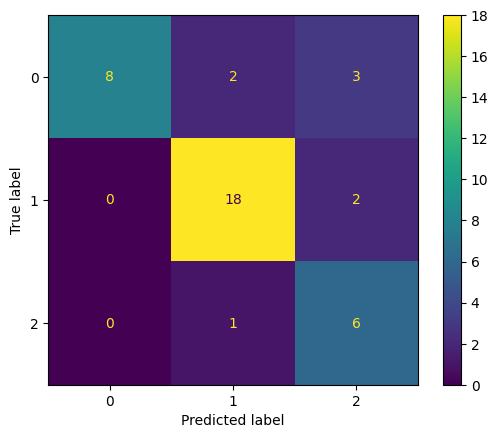

In [117]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_true_classes, y_pred_classes, zero_division=1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()